In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
#Optimizer
from keras.optimizers import SGD
#Dataset
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import Resnet
from keras.applications.resnet import ResNet50 , preprocess_input
# Import Early Stopping
from keras.callbacks import EarlyStopping
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# Google drive
from google.colab import drive

Using TensorFlow backend.


In [2]:
PATH = "/content/"
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!rm -rf "/content/images"
!unzip -q "/content/drive/My Drive/P2VC/caltech" -d "/content/"
!ls

drive  images  sample_data


In [0]:
def read_img (path_list):
    classes = np.array([path.split('/')[0] for path in path_list])
    vim = np.array([img_to_array(load_img(PATH + "images/"+ im, target_size = (224,224,3))) 
                    for im in path_list])

    return vim, classes

def load_caltech_data():

    # Load files with paths
    train_path = np.loadtxt(PATH + "images/train.txt", dtype = str)
    test_path = np.loadtxt(PATH + "images/test.txt", dtype = str)

    # Read imgs
    print("Loading data...")
    x_train, y_train = read_img(train_path)
    x_test, y_test = read_img(test_path)
    print("Data loaded.")

    # Set classes to numerical
    unique_classes = np.unique(np.copy(y_train))
    for i in range(len(unique_classes)):
      y_train[y_train == unique_classes[i]] = i
      y_test[y_test == unique_classes[i]] = i

    # Set classes to categorical
    y_train = np_utils.to_categorical(y_train, 200)
    y_test = np_utils.to_categorical(y_test, 200)

    # Shuffle data
    x_train_perm = np.random.permutation(len(x_train))
    x_train = x_train[x_train_perm]
    y_train = y_train[x_train_perm]

    x_test_perm = np.random.permutation(len(x_test))
    x_test = x_test[x_test_perm]
    y_test = y_test[x_test_perm]

    return x_train, y_train, x_test, y_test

In [0]:
def calculateAccuracy(labels, preds):
  labels = np.argmax(labels, axis=1)
  preds = np.argmax(preds, axis=1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


def showEvolution(hist):

    #Loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    #Accuracy
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()


def compareHists(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()

In [0]:
def data_augmentation_datagen():
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation            
    horizontal_flip=True,                 # randomly horizontal flip images
    zoom_range = 0.2,
    validation_split = 0.1)
  return datagen

def normalize_datagen_test():
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation         
  )
  return datagen

In [0]:
def train_and_show(model,train_data_gen,test_data_gen = normalize_datagen_test, data_loader = load_caltech_data,early_stopping = False,batch_size = 32,epochs = 50):
  # Declare optimizer : SGD
  opt = SGD(lr = 0.01,decay = 1e-6,momentum = 0.9,nesterov = True)
  #Compile model:
  model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = opt,  
        metrics = ['accuracy'])
  # Images
  x_train , y_train , x_test , y_test = data_loader()
  # Data generation object for train and test
  datagen = train_data_gen()
  datagen_test = test_data_gen()
  # Data fit, in case we used featurewise_center and/or featurewise_std_normalization  in the dataGen
  datagen.fit(x_train)
  datagen_test.fit(x_train)
  # Create train,test and validation sets
  train = datagen.flow(x_train,
                     y_train,
                     batch_size = batch_size, 
                     subset = 'training')
  validation = datagen.flow(x_train,
                          y_train,
                          batch_size = batch_size,
                          subset = 'validation')
  test = datagen_test.flow(x_test,
                           batch_size = 1,
                           shuffle = False)
  # Check early stopping
  callbacks = []
  if early_stopping:
    callbacks.append(EarlyStopping(monitor='val_loss', patience=2,restore_best_weights = True))
  # Generate histogram, fitting generator
  hist = model.fit_generator(generator = train, 
                            steps_per_epoch = len(x_train)*0.9/batch_size,
                            epochs = epochs, 
                            validation_data = validation,
                            validation_steps = len(x_train)*0.1/batch_size,
                            verbose = 2,
                            callbacks = callbacks
                            )
  
  pred = model.predict_generator(test,
                                 steps = len(test))
  score = calculateAccuracy(y_test,pred)
  print("TEST SCORE =  "+str(score))
  return hist

# Transferencia de Modelos y Fine Tuning

En esta sección, trataremos de utilizar modelos ya existentes sobre un problema concreto que se nos ha proporcionado: la clasificación de tipos de pájaros. Utilizaremos el modelos previamente entrenados y veremos cómo de bien funciona este modelo sobre nuestro problema.


A partir de ahora utilizaremos una base de datos diferente. Será la base de datos *Caltech-UCSD*. Este conjunto tiene 200 clases diferentes con 3000 imágenes en el *train set* y 3033 en el *test set*. Dejaremos de nuevo un $10\%$ del *train set* para la validación.

## Transferencia de modelos

Vamos a usar como extractor de características el modelo **ResNet50**, preentrenado en *ImageNet*. Especificaremos la opción *pooling = 'avg'*, para que se nos devuelva de la función el modelo con una capa *GlobalAveragePooling* al final, teniendo entonces la salida en una dimensión.

Con el parámetro *include_top = False*, estamos quitando la última capa que clasificaba las imágenes, así que nos servirá para extraer las características, que es lo que queremos. A la función que nos creará el modelo A la función que nos crea el modelo, se le pasará un parámetro *freeze* , que nos servirá para *fine-tuning* y será explicado más adelante.


Tendremos como salida un vector de 2048 características, con el que podremos entrenar otro modelo. Para comenzar, lo usaremos como extractor de características y añadiremos únicamente una capa *Dense* para comprobar si las características extraidas son buenas para nuestro modelo o no.

In [0]:
def res_net_50(freeze = True,num_freeze = 0):
  resnet50 = ResNet50(weights='imagenet', 
                      include_top=False,
                      pooling="avg",
                      input_shape=(224,224,3))
  # Freeze layers for fine-tuning
  if freeze:
    for layer in resnet50.layers[:num_freeze]:
      if (not isinstance(layer, keras.layers.BatchNormalization)):
        layer.trainable = False
      
  # new model to add softmax
  x = resnet50.output
  # Adding softmax
  x = Dense(200,activation = 'softmax')(x)
  model = Model(inputs = resnet50.input, outputs = x)
  return model

94773248/94765736 [==============================] - 3s 0us/step
Loading data...
Data loaded.
Epoch 1/10
 - 39s - loss: 4.6791 - acc: 0.0833 - val_loss: 4.4403 - val_acc: 0.1233
Epoch 2/10
 - 28s - loss: 2.6000 - acc: 0.3741 - val_loss: 4.5797 - val_acc: 0.1133
Epoch 3/10
 - 29s - loss: 1.3806 - acc: 0.6331 - val_loss: 3.8728 - val_acc: 0.2267
Epoch 4/10
 - 29s - loss: 0.7125 - acc: 0.8121 - val_loss: 3.4255 - val_acc: 0.2800
Epoch 5/10
 - 29s - loss: 0.3778 - acc: 0.9045 - val_loss: 4.1430 - val_acc: 0.1933
Epoch 6/10
 - 29s - loss: 0.2032 - acc: 0.9610 - val_loss: 2.8232 - val_acc: 0.3900
Epoch 7/10
 - 29s - loss: 0.1137 - acc: 0.9790 - val_loss: 2.7931 - val_acc: 0.4100
Epoch 8/10
 - 29s - loss: 0.0670 - acc: 0.9904 - val_loss: 2.6032 - val_acc: 0.4567
Epoch 9/10
 - 29s - loss: 0.0411 - acc: 0.9934 - val_loss: 2.6877 - val_acc: 0.4067
Epoch 10/10
 - 29s - loss: 0.0409 - acc: 0.9926 - val_loss: 2.7828 - val_acc: 0.4100
TEST SCORE =  0.3425651170458292


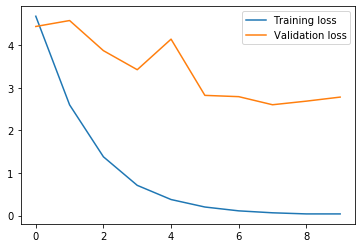

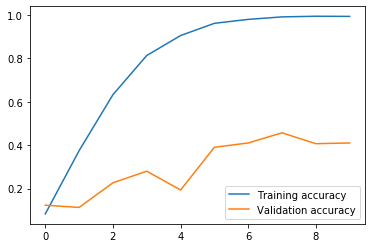

In [9]:
model = res_net_50(freeze = True)

hist = train_and_show(model,data_augmentation_datagen,data_loader = load_caltech_data,epochs = 10)
showEvolution(hist)

Podemos observar varias cosas de estos resultados

1. El modelo entrena muy bien en el conjunto de *train*. Esto es fácilmente observable en que la función *loss* tiende a $0$ solamente con 10 épocas. Además, también llega casi a un $100\%$ de acierto en este mismo conjunto.
2. Sin embargo, podemos ver que estas dos funciones tienen valores bastante malos en el conjunto de validación, comparados con los que hemos visto que toma en el conjunto de *train*.
3. El *score* que obtenemos al final (entorno a $0.35$), se asemeja bastante a los valores que se obtienen durante las épocas en el conjunto de validación. Sin embargo, se aleja bastante (al igual que los de validación), del acierto en el conjunto de *train*.

Con estos tres puntos, podemos decir que el modelo está aprendiendo bastante pero solamente del conjunto de entrenamiento y no es un buen aprendizaje para la base de datos en general.


## Fine- Tuning

En el uso práctico de *CNNs*, los modelos suelen tener una cantidad inmensa de parámetros que es complicado entrenar. Es por ello que se suele utilizar ***fine-tuning*** sobre estos modelos para no tener que entrenarlos de forma completa y partir ya de un entrenamiento previo de estos. Esto se puede hacer de forma general porque el entrenamiento que suelen tener ha sido hecho en *datasets* de tamaño mucho mayor que el que nosotros utilizaremos normalmente (como en este caso, que el número de imágenes que tenemos es bastante reducido, poco más de 6K), y por tanto el modelo habrá aprendido características que serán potencialmente buenas para nuestros datos.

Una práctica bastante recomendada al hacer *fine-tuning* es la de hacer **freeze**, que consiste en congelar determinadas capas de nuestro modelo para que , si vuelves a entrenar el modelo de forma completa, estas capas no hagan el entrenamiento. 

Esto podría hacerse para mantener las primeras capas, que suelen preocuparse de recoger características más generales (curvas,bordes), intactas pues queremos mantener ese conocimiento en nuestro modelo. Es por ello que pasaremos *freeze = true* cuando queramos hacer *fine-tuning* de nuestra red, y esto hará que todas las capas del modelo inicial se congelen. 

Hay que tener cuidado pues parece que hay un **bug**, y *keras* no congela bien las capas que son de *BatchNormalization*. Es por ello por lo que hemos añadido un *if* en nuestro código que comprueba si es o no una capa de *BatchNormalization*, y si lo es, no congela esa capa. De todos modos, estas capas son **no-entrenables**, así que no supone un problema para el entrenamiento de nuestro modelo.

Vamos ahora a probar a hacer *fine-tuning* con la red completa, por lo que será suficiente enviar el parámetro *freeze = False*.


Loading data...
Data loaded.
Epoch 1/10
 - 39s - loss: 4.7638 - acc: 0.0710 - val_loss: 5.3321 - val_acc: 0.0767
Epoch 2/10
 - 28s - loss: 2.5845 - acc: 0.3663 - val_loss: 4.3367 - val_acc: 0.1300
Epoch 3/10
 - 29s - loss: 1.3955 - acc: 0.6275 - val_loss: 3.6045 - val_acc: 0.2300
Epoch 4/10
 - 29s - loss: 0.7243 - acc: 0.8092 - val_loss: 3.4533 - val_acc: 0.3067
Epoch 5/10
 - 29s - loss: 0.4118 - acc: 0.9032 - val_loss: 3.2485 - val_acc: 0.3500
Epoch 6/10
 - 29s - loss: 0.1971 - acc: 0.9592 - val_loss: 2.9341 - val_acc: 0.3733
Epoch 7/10
 - 29s - loss: 0.1075 - acc: 0.9810 - val_loss: 2.9063 - val_acc: 0.4233
Epoch 8/10
 - 29s - loss: 0.0515 - acc: 0.9915 - val_loss: 2.6611 - val_acc: 0.4467
Epoch 9/10
 - 29s - loss: 0.0343 - acc: 0.9960 - val_loss: 2.6431 - val_acc: 0.4333
Epoch 10/10
 - 29s - loss: 0.0331 - acc: 0.9963 - val_loss: 2.5907 - val_acc: 0.4600
TEST SCORE =  0.36993076162215627


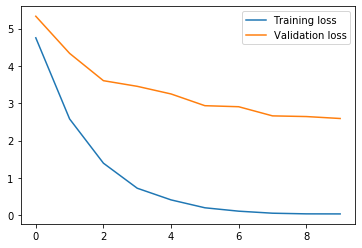

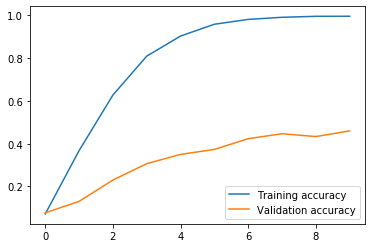

In [10]:
model2 = res_net_50(freeze = False)

hist2 = train_and_show(model2,data_augmentation_datagen,data_loader = load_caltech_data,epochs = 10)
showEvolution(hist2)

Las gráficas de validación parecen en este caso estar más alejadas del *training* que en el caso anterior. Sin embargo, también parecen un poco menos estabilizadas que las anteriores, por lo que con el paso de las épocas podrían ir acerándose más a los buenos resultados también en la validación. Vamos a ver una comparación  entre las funciones de pérdida y de *accuracy* en el conjunto de validación para los dos tipos de modelos.

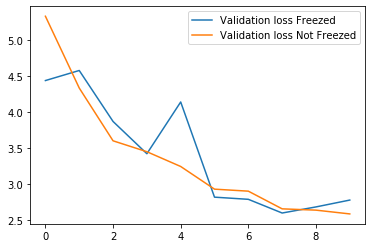

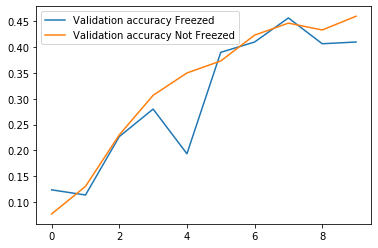

In [11]:
compareHists([hist,hist2],["Freezed", "Not Freezed"])

Podemos ver como, al no congelar el modelo:
- La función depérdida es menor
- El *accuracy* en la validación acaba siendo mayor aunque tarde un poco en superar al modelo que sí está congelado.

Esto podría indicar que al fin y al cabo el modelo que no congela acabará ajustando los datos mejor que el modelo que utiliza como extractor de características a *ResNet50*.

## Añadiendo capas a nuestro extractor de características

Vamos a probar a añadir algunas capas más a parte de únicamente el *Softmax* y *Dense* a Resnet, para ver si conseguimos mejorar algo su resultado.


In [0]:
def res_net_50_plus(freeze = True,num_freeze = 0):
  resnet50 = ResNet50(weights='imagenet', 
                      include_top=False,
                      pooling="avg",
                      input_shape=(224,224,3))
  # Freeze layers for fine-tuning
  if freeze:
    for layer in resnet50.layers[:num_freeze]:
      if (not isinstance(layer, keras.layers.BatchNormalization)):
        layer.trainable = False
      
  # new model to add softmax
  x = resnet50.output
  # Adding softmax
  x = Dense(1024,activation = 'relu')(x)
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)
  x = Dense(512)(x)
  x = Dense(256,activation = 'relu')(x)
  x = Dense(200,activation = 'softmax')(x)
  
  model = Model(inputs = resnet50.input, outputs = x)
  return model

Hemos añadido después de las capas de *ResNet50* las siguientes capas para tratar de realizar una disminución progresiva de tamaño:
- Una capa *Dense(1024)*, para reducir el tamaño a la mitad, seguida por una activación *Relu*
- Un *Dropout* de $rate = 0.5$, para tratar de eliminar un gran número de parámetros
- Otra capa *Dense(512)*, reduciendo de nuevo el tamaño
- Una última capa *Dense(256)* antes de la capa que tiene la activación *Softmax*

Veamos si da buenos resultados:

Loading data...
Data loaded.
Epoch 1/10
 - 47s - loss: 5.4947 - acc: 0.0132 - val_loss: 5.2613 - val_acc: 0.0067
Epoch 2/10
 - 27s - loss: 5.0394 - acc: 0.0274 - val_loss: 6.2659 - val_acc: 0.0333
Epoch 3/10
 - 29s - loss: 4.5328 - acc: 0.0588 - val_loss: 5.8333 - val_acc: 0.0200
Epoch 4/10
 - 29s - loss: 4.0696 - acc: 0.0994 - val_loss: 4.7748 - val_acc: 0.0433
Epoch 5/10
 - 29s - loss: 3.6369 - acc: 0.1471 - val_loss: 4.2270 - val_acc: 0.0633
Epoch 6/10
 - 29s - loss: 3.2455 - acc: 0.1994 - val_loss: 4.2915 - val_acc: 0.1000
Epoch 7/10
 - 29s - loss: 2.9517 - acc: 0.2458 - val_loss: 3.9664 - val_acc: 0.1567
Epoch 8/10
 - 29s - loss: 2.5842 - acc: 0.3147 - val_loss: 3.9633 - val_acc: 0.1567
Epoch 9/10
 - 29s - loss: 2.4104 - acc: 0.3391 - val_loss: 4.2999 - val_acc: 0.1467
Epoch 10/10
 - 29s - loss: 2.2110 - acc: 0.3903 - val_loss: 4.1898 - val_acc: 0.1767
TEST SCORE =  0.14968677876689745


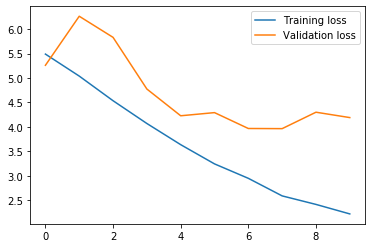

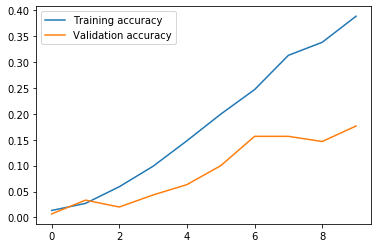

In [17]:
model_plus = res_net_50_plus(freeze = True,num_freeze = 10)
hist_plus = train_and_show(model_plus,data_augmentation_datagen,epochs = 10)
showEvolution(hist_plus)

Los resultados son estrepitosos. El modelo no es capaz de alcanzar ni un acierto de $0.15$ en el conjunto de test, aunque su función de pérdida disminuya de forma tan drástica, vemos que el acierto en la validación no aumenta tanto como el acierto en *training*, que, por otro lado, aumenta de forma mucho más lenta que en los casos anteriores.

Descartaremos estos cambios al no haber sido una mejora sustancial del modelo.

## Usando Fine-Tuning en parte de la red

Por último, vamos a hacer una pequeña prueba. Como he comentado antes, en fine-tuning puede decidirse congelar una serie de capas, y no todas. En concreto, podría ser interesante congelar todas las primeras capas y dejar las Z últimas sin congelar, para tratar de usar las primeras como extractores de "características básicas" de las imágenes , y entrenar las últimas para usarlas en nuestra base de datos concreta.

Es para ello para lo que le hemos añadido a nuestro modelo un parámetro con el cual podremos indicar cuántos layers (empezando por el final) querremos no congelar. Vamos a hacer una prueba con Z=10, y veremos el resultado:

Loading data...
Data loaded.
Epoch 1/10
 - 44s - loss: 4.5493 - acc: 0.1059 - val_loss: 6.1773 - val_acc: 0.0667
Epoch 2/10
 - 28s - loss: 2.3067 - acc: 0.4235 - val_loss: 4.0193 - val_acc: 0.1600
Epoch 3/10
 - 30s - loss: 1.1768 - acc: 0.6853 - val_loss: 2.9048 - val_acc: 0.3467
Epoch 4/10
 - 29s - loss: 0.5413 - acc: 0.8504 - val_loss: 3.0727 - val_acc: 0.3133
Epoch 5/10
 - 29s - loss: 0.2921 - acc: 0.9352 - val_loss: 2.6669 - val_acc: 0.4300
Epoch 6/10
 - 30s - loss: 0.1482 - acc: 0.9716 - val_loss: 2.7317 - val_acc: 0.3900
Epoch 7/10
 - 30s - loss: 0.0896 - acc: 0.9875 - val_loss: 2.2317 - val_acc: 0.4933
Epoch 8/10
 - 29s - loss: 0.0511 - acc: 0.9941 - val_loss: 2.2679 - val_acc: 0.4633
Epoch 9/10
 - 29s - loss: 0.0329 - acc: 0.9960 - val_loss: 2.1463 - val_acc: 0.5233
Epoch 10/10
 - 29s - loss: 0.0269 - acc: 0.9950 - val_loss: 2.1032 - val_acc: 0.5200
TEST SCORE =  0.4038905374216947


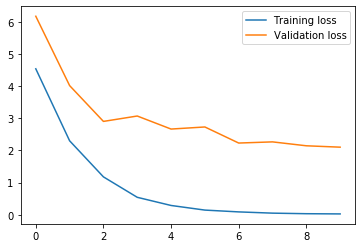

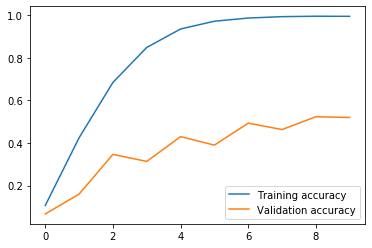

In [13]:
model3 = res_net_50(freeze = True,num_freeze = 10)
hist_freeze10 = train_and_show(model3,data_augmentation_datagen,epochs = 10)
showEvolution(hist_freeze10)

Podemos comprobar como, en este caso, se estabilizan más pronto las funciones tanto de validación como de pérdida

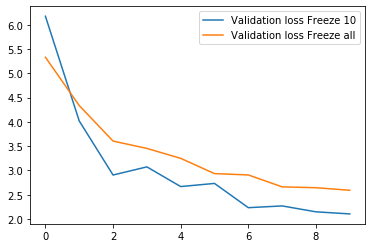

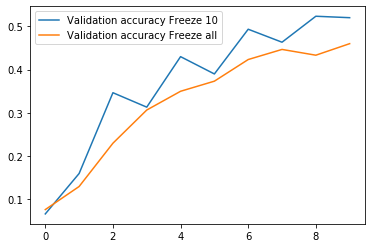

In [18]:
compareHists([hist_freeze10,hist2],["Freeze 10", "Freeze all"])

# Conclusiones

Durante la práctica, hemos tratado de empezar con un modelo básico de red neuronal convolucional , **BaseNet** y hemos ido tratando de mejorarla poco a poco, hasta llegar a un modelo que tiene un porcentaje de acierto en el conjunto de *test* bastante decente, $0.58$.

Hemos descubierto que muchas veces, añadir más épocas o más capas a los modelos pueden llevarnos a *overfitting* y por tanto no nos interesa introducir capas aleatoriamente ni poner un número de épocas muy elevado.

Además, hemos encontrado que utilizar *Dropouts* mejora sustancialmente los resultados en cuanto a menor diferencia entre las gráficas de la función de pérdida del conjunto de validación y el de entrenamiento, así como de la función de acierto, por lo que es una de las mejores mejoras que se le pueden añadir a nuestro modelo, aunque hay que tener cuidado de establecer un $rate$ adecuado.

Por último, hemos tratado de usar una red ya entrenada , **ResNet50**, con los pesos de otro conjunto de Datos para ver cómo se comporta utilizándola en una base de datos propia. Hemos obtenido unos resultados que son, en general, bastante malos, no superando el $40\%$ de acierto incluso tratando de hacer diversas modificaciones y mejoras, como añadir capas, o congelar un número determinado de capas mediante *fine-tuning*.

# Bibliografía

https://marubon-ds.blogspot.com/2017/08/how-to-make-fine-tuning-model.html

https://keras.io/preprocessing/image/

https://en.m.wikipedia.org/wiki/Softmax_function

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html

https://arxiv.org/pdf/1512.00242.pdf